### Midterm Project
### Heart Disease Classifier

__Description__

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [77]:
df = pd.read_csv('heart_cleveland_upload.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


__Dataset features description__\
•	Age (in years)\
•	Sex (Gender: 0-male, 1-female)\
•	cp – chest pain type (values 0-3)\
•	trestbps – resting blood pressure (in mm Hg)\
•	chol – serum cholesterol (in mm/dl)\
•	fbs – fasting blood sugar > 120 mg/dl (1:true, 0:false)\
•	restecg – resting electrocardiographic results (values 0-2)\
•	thalack – max heart rate\
•	exang – exercise induced angina (1:yes, 0:no)\
•	oldpeak – ST depression induced by exercise relative to rest\
•	slope – the slope of the peak exercise ST segment (values 0-2)\
•	ca – number of major vessels(0-4) coloured by flourosopy\
•	thal (0:normal, 1:fixed_defect, 2:reversable_defect)\
and condition which is the label / target.

In [47]:
df.shape

(297, 14)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [49]:
df.nunique()

age           41
sex            2
cp             4
trestbps      50
chol         152
fbs            2
restecg        3
thalach       91
exang          2
oldpeak       40
slope          3
ca             4
thal           3
condition      2
dtype: int64

In [78]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical = ['sex', 'fbs', 'exang', 'condition', 'cp', 'restecg', 'slope', 'ca', 'thal']

cat_map_to_string = {
    'sex'       : ['female', 'male'],
    'fbs'       : ['false', 'true'],
    'exang'     : ['no', 'yes'], 
    'condition' : ['no_disease', 'disease'], 
    'cp'        : ["typical_angina", "atypical_angina", "non_anginal_pain", "asymtomatic"], 
    'restecg'   : ['normal', 'st-t_wave_abnormality', 'left_ventricular_hypertrophy'], 
    'slope'     : ['upsloping', 'flat', 'downsloping'], 
    'ca'        : ['zero', 'one', 'two', 'three'], 
    'thal'      : ['normal', 'fixed_defect', 'reversable_defect']
}

In [79]:
for cat in categorical:
    c = cat_map_to_string[cat]
    df[cat] = df[cat].map(lambda x: c[x])

In [52]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,male,typical_angina,160,234,true,left_ventricular_hypertrophy,131,no,0.1,flat,one,normal,no_disease
1,69,female,typical_angina,140,239,false,normal,151,no,1.8,upsloping,two,normal,no_disease
2,66,female,typical_angina,150,226,false,normal,114,no,2.6,downsloping,zero,normal,no_disease
3,65,male,typical_angina,138,282,true,left_ventricular_hypertrophy,174,no,1.4,flat,one,normal,disease
4,64,male,typical_angina,110,211,false,left_ventricular_hypertrophy,144,yes,1.8,flat,zero,normal,no_disease


__EDA__

male      201
female     96
Name: sex, dtype: int64

<AxesSubplot:xlabel='sex', ylabel='Count'>

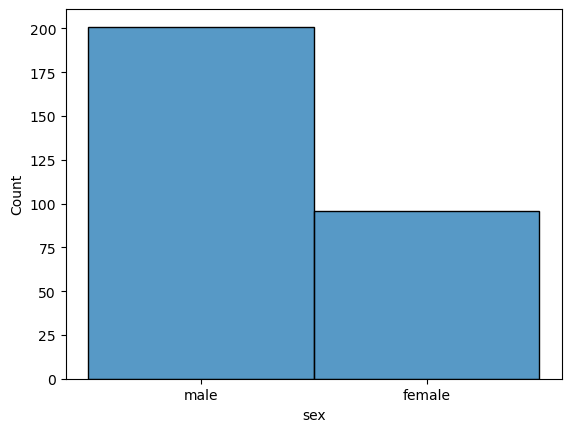

In [53]:
display(df.sex.value_counts())
sns.histplot(df.sex)

<AxesSubplot:xlabel='sex'>

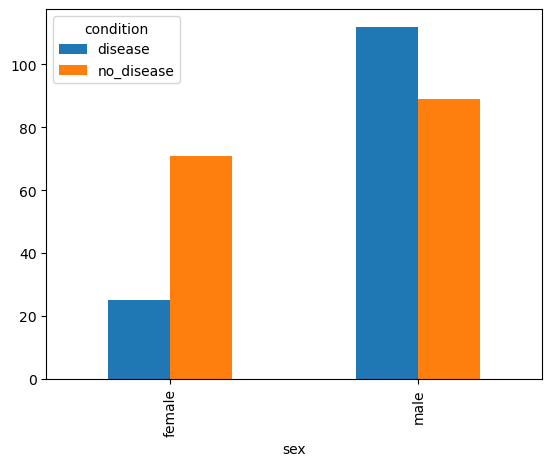

In [58]:
pd.crosstab(df.sex, df.condition).plot(kind='bar')

In [54]:
for c in categorical:
    display(df[c].value_counts())
    print('-----'*10)

male      201
female     96
Name: sex, dtype: int64

--------------------------------------------------


false    254
true      43
Name: fbs, dtype: int64

--------------------------------------------------


no     200
yes     97
Name: exang, dtype: int64

--------------------------------------------------


no_disease    160
disease       137
Name: condition, dtype: int64

--------------------------------------------------


asymtomatic         142
non_anginal_pain     83
atypical_angina      49
typical_angina       23
Name: cp, dtype: int64

--------------------------------------------------


normal                          147
left_ventricular_hypertrophy    146
st-t_wave_abnormality             4
Name: restecg, dtype: int64

--------------------------------------------------


upsloping      139
flat           137
downsloping     21
Name: slope, dtype: int64

--------------------------------------------------


zero     174
one       65
two       38
three     20
Name: ca, dtype: int64

--------------------------------------------------


normal               164
reversable_defect    115
fixed_defect          18
Name: thal, dtype: int64

--------------------------------------------------


In [55]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.54,9.05,29.0,48.0,56.0,61.0,77.0
trestbps,297.0,131.69,17.76,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.35,52.00,126.0,211.0,243.0,276.0,564.0
thalach,297.0,149.60,22.94,71.0,133.0,153.0,166.0,202.0
oldpeak,297.0,1.06,1.17,0.0,0.0,0.8,1.6,6.2


<AxesSubplot:xlabel='age', ylabel='Count'>

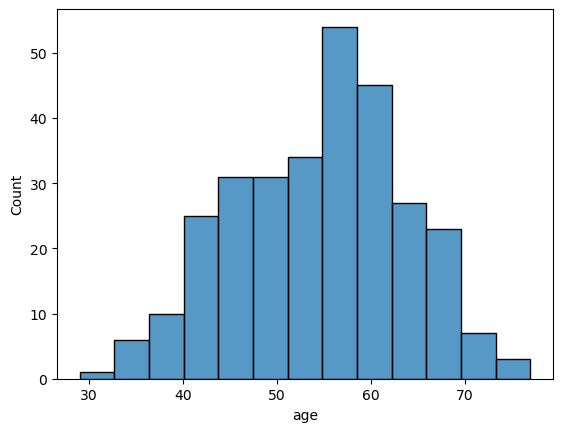

In [56]:
sns.histplot(df.age)

In [80]:
df.condition = df.condition.map({'no_disease':0, 'disease':1})
df.condition.value_counts()

0    160
1    137
Name: condition, dtype: int64

<AxesSubplot:>

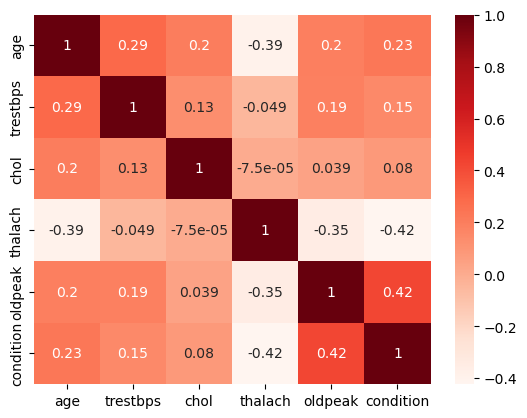

In [81]:
sns.heatmap(df.corr(), annot=True, cmap='Reds')

In [84]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2
condition,297.0,0.461279,0.499340,0.0,0.0,0.0,1.0,1.0


In [86]:
for n in numerical:
    df[n] = MinMaxScaler().fit_transform(df[n].values.reshape(-1, 1))


In [88]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,0.532127,0.188536,0.0,0.395833,0.562500,0.666667,1.0
trestbps,297.0,0.355600,0.167574,0.0,0.245283,0.339623,0.433962,1.0
chol,297.0,0.277055,0.118716,0.0,0.194064,0.267123,0.342466,1.0
thalach,297.0,0.599995,0.175126,0.0,0.473282,0.625954,0.725191,1.0
oldpeak,297.0,0.170251,0.188084,0.0,0.000000,0.129032,0.258065,1.0
condition,297.0,0.461279,0.499340,0.0,0.000000,0.000000,1.000000,1.0


In [89]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=49)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=49)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.condition.values
y_val = df_val.condition.values
y_test = df_test.condition.values

del df_train['condition']
del df_val['condition']
del df_test['condition']

In [90]:
train_dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [91]:
X_train.shape

(177, 28)

In [130]:
full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(full_train_dicts)
y_full_train = df_full_train.condition.values

test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [92]:
model_LR = LogisticRegression(random_state=49)
model_LR.fit(X_train, y_train)

LogisticRegression(random_state=49)

In [98]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model_LR.predict_proba(X_val)[:, 1]

In [94]:
def evaluate_model(model, x_test, y_test, label='model'):

    y_pred= model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1 Score:', f1) 
    print('Confusion Matrix:\n', cm)

    y_pred_proba = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], label='random')

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

    print('Area Under Curve:', auc)
    
    


__Logistic Regression__

Accuracy: 0.8333333333333334
Precision: 0.8
Recall: 0.8
F1 Score: 0.8000000000000002
Confusion Matrix:
 [[30  5]
 [ 5 20]]
Area Under Curve: 0.864


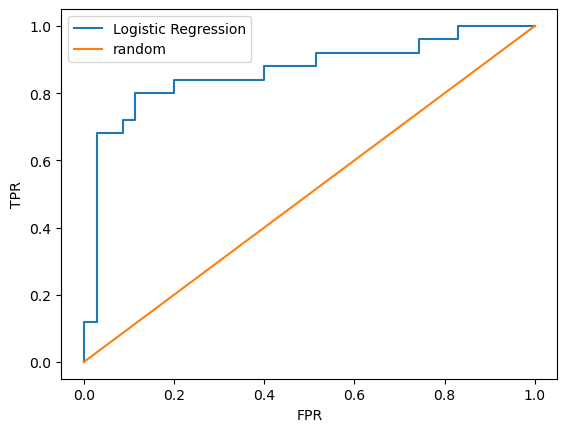

In [97]:
evaluate_model(model_LR, X_val, y_val, label='Logistic Regression')

In [99]:
max_iter_values = list(range(100, 1001, 100))
scores = []
for max_iter in max_iter_values:
    model = LogisticRegression(max_iter=max_iter, random_state=49)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


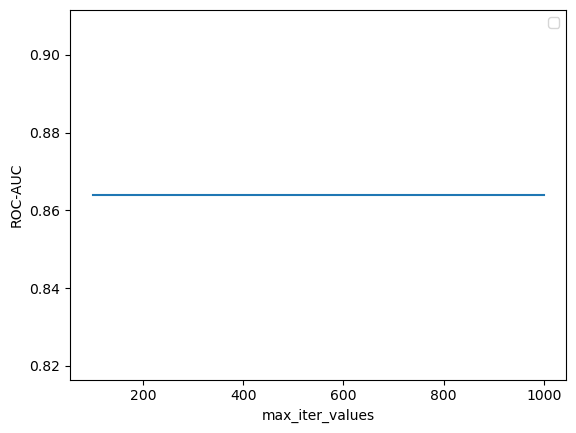

In [100]:
plt.plot(max_iter_values, scores)
plt.xlabel('max_iter_values')
plt.ylabel('ROC-AUC')
plt.legend()

In [116]:
C_values = [0.001, 0.003,  0.01, 0.03, 0.1,0.3, 1, 10, 25]
scores = []

for C in C_values:
    model = LogisticRegression(C=C, random_state=49)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


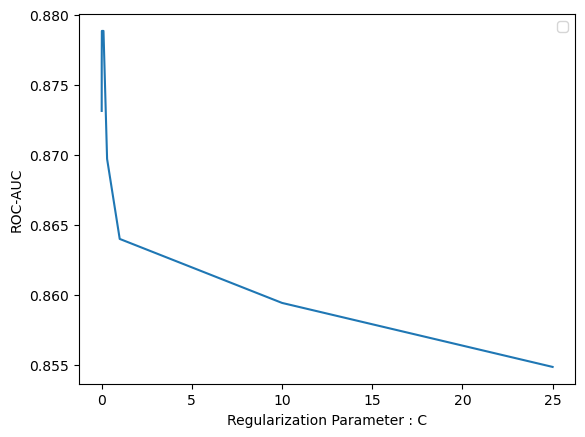

In [117]:
plt.plot(C_values, scores)
plt.xlabel('Regularization Parameter : C')
plt.ylabel('ROC-AUC')
plt.legend()

In [118]:
C_values[
    np.argmax(scores)
]

0.01

So C regularization parameter's value is 0.01

In [120]:

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scores = []

for S in solvers:
    model = LogisticRegression(C=0.01,solver=S, random_state=49)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


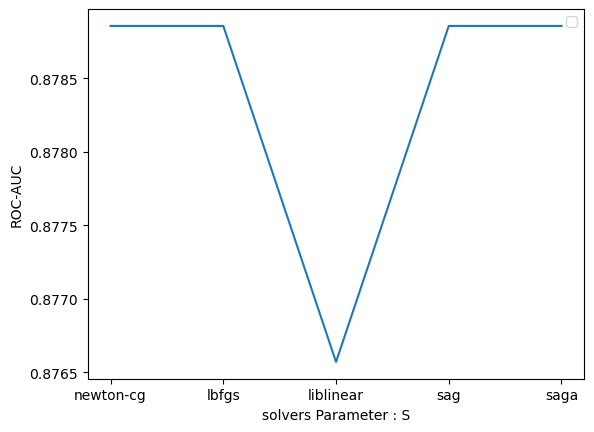

In [121]:
plt.plot(solvers, scores)
plt.xlabel('solvers Parameter : S')
plt.ylabel('ROC-AUC')
plt.legend()

Accuracy: 0.8166666666666667
Precision: 0.8846153846153846
Recall: 0.7419354838709677
F1 Score: 0.8070175438596492
Confusion Matrix:
 [[26  3]
 [ 8 23]]
Area Under Curve: 0.9054505005561736


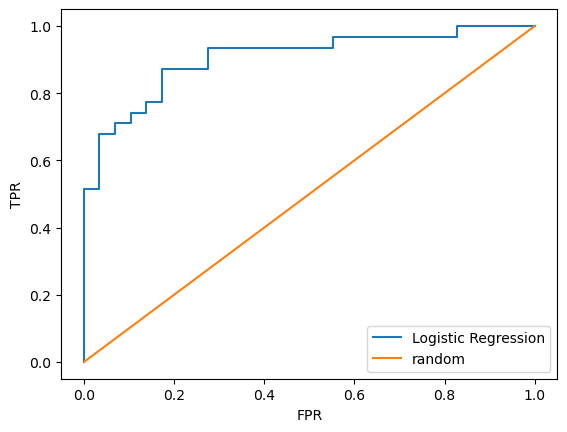

In [131]:
model_LR_1 = LogisticRegression(C=0.01, random_state=49)
model_LR_1.fit(X_full_train, y_full_train)

evaluate_model(model_LR_1, X_test, y_test, label='Logistic Regression')

__Decision Trees__

In [ ]:
model_DT = DecisionTreeClassifier()